# Контрольная работа №2
# Комарист Катя, ЕК-61
## Вариант 2

In [21]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns

import math
import re

import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np

from datetime import date, timedelta
import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots
import plotly.express as px

ply.init_notebook_mode(connected=True)

from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling


import plotly.graph_objects as go
%matplotlib inline

Загружаем данные и ознакамливаемся с ними

In [22]:
data = pd.read_csv('data_komarist_v2.csv', sep=';',decimal=",")
df = data.copy()

In [23]:
data.head()

Age Sex   ALP   ALT    CHE  CHOL   CREA   GGT  PROT  Category
0   32   m  52.5   7.7   6.93  3.23  106.0  12.1  69.0         0
1   32   m  70.3  18.0  11.17  4.80   74.0  15.6  76.5         0
2   32   m  74.7  36.2   8.84  5.20   86.0  33.2  79.3         0
3   32   m  52.0  30.6   7.33  4.74   80.0  33.8  75.7         0
4   32   m  74.1  32.6   9.15  4.32   76.0  29.9  68.7         0

In [24]:
info = []
for column in data.columns:
        vals = {"col": column,
                "na_count": data[column].isna().sum(),
               "nunique": data[column].nunique(),
               "unique": data[column].unique(),
                "type": data[column].dtype
               }
        info.append(vals)
pd.DataFrame(info).sort_values(by = "na_count", ascending = False)

col  na_count  nunique  \
2       ALP        18      414   
5      CHOL        10      313   
3       ALT         1      341   
8      PROT         1      198   
0       Age         0       49   
1       Sex         0        2   
4       CHE         0      407   
6      CREA         0      117   
7       GGT         0      358   
9  Category         0        2   

                                              unique     type  
2  [52.5, 70.3, 74.7, 52.0, 74.1, 43.3, 41.3, 41....  float64  
5  [3.23, 4.8, 5.2, 4.74, 4.32, 6.05, 4.79, 4.6, ...  float64  
3  [7.7, 18.0, 36.2, 30.6, 32.6, 18.5, 17.5, 35.8...  float64  
8  [69.0, 76.5, 79.3, 75.7, 68.7, 74.0, 74.5, 67....  float64  
0  [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...    int64  
1                                             [m, f]   object  
4  [6.93, 11.17, 8.84, 7.33, 9.15, 9.92, 7.01, 5....  float64  
6  [106.0, 74.0, 86.0, 80.0, 76.0, 111.0, 70.0, 1...  float64  
7  [12.1, 15.6, 33.2, 33.8, 29.9, 91.0, 16.9, 21....  float64  
9                                             [0, 1]    int64

Датасет имеет 10 переменных, среди которых одна - категории (для классификации). В четырех переменных присутствуют пропуски. Переменная Sex - категориальная и будет преобразована в булевую (m=1, f=0).

In [25]:
df['Sex'] = df['Sex'].map({'m':1, 'f':0})

Визуализируем распределение переменных

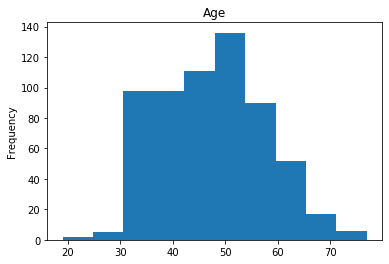

In [26]:
df['Age'].plot(kind = 'hist', title='Age')

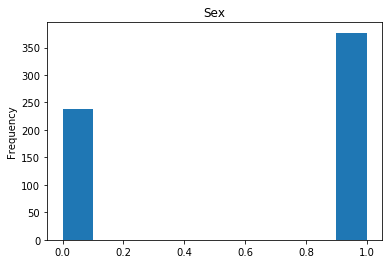

In [27]:
df['Sex'].plot(kind = 'hist', title='Sex')

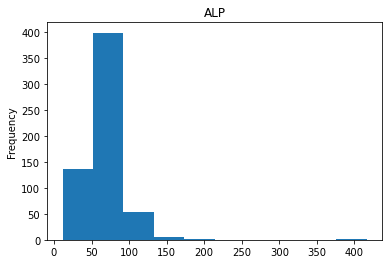

In [30]:
df['ALP'].plot(kind = 'hist', title='ALP')

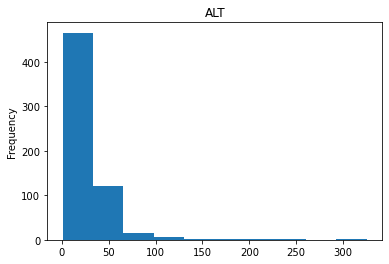

In [31]:
df['ALT'].plot(kind = 'hist', title='ALT')

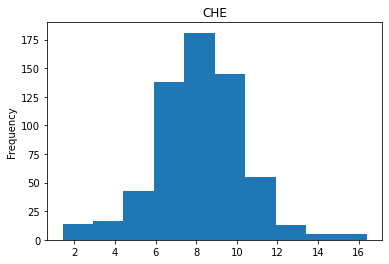

In [32]:
df['CHE'].plot(kind = 'hist', title='CHE')

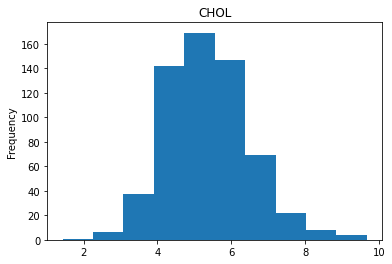

In [33]:
df['CHOL'].plot(kind = 'hist', title='CHOL')

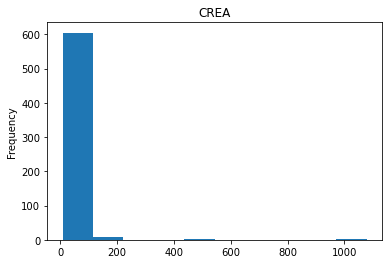

In [34]:
df['CREA'].plot(kind = 'hist', title='CREA')

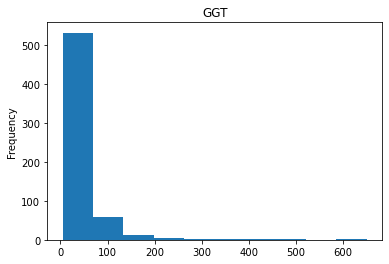

In [35]:
df['GGT'].plot(kind = 'hist', title='GGT')

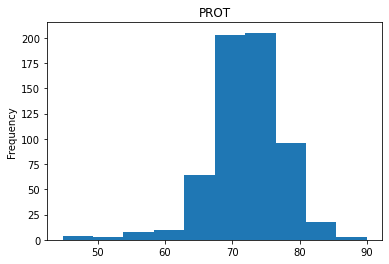

In [36]:
df['PROT'].plot(kind = 'hist', title='PROT')

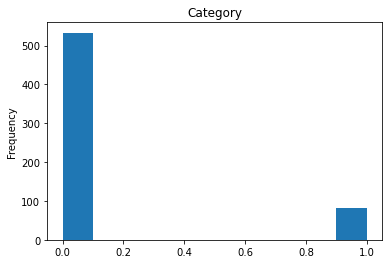

In [37]:
df['Category'].plot(kind = 'hist', title='Category')

Переменные 'GGT', 'ALP', 'ALT' имеют распределение отличное от нормального, поэтому будут прологарифмированы.

In [28]:
for i in ['GGT', 'ALP', "ALT"]:
    df[i] = np.log(df[i])

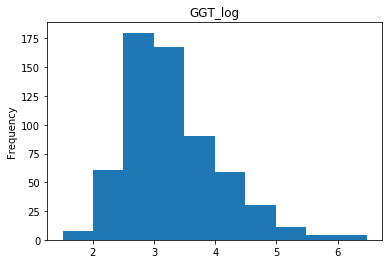

In [29]:
df['GGT'].plot(kind = 'hist', title='GGT_log')

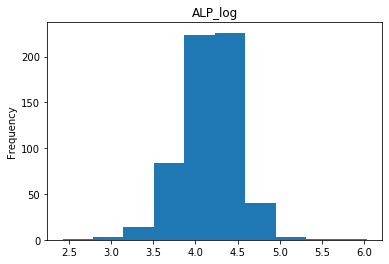

In [30]:
df['ALP'].plot(kind = 'hist', title='ALP_log')

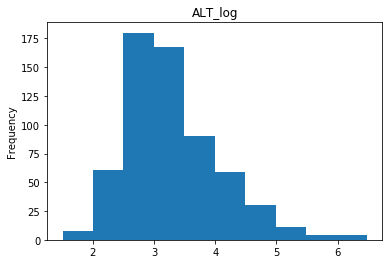

In [31]:
df['GGT'].plot(kind = 'hist', title='ALT_log')

Избавляемся от выбросов

In [32]:
# Function Outliers
def outliers(df):
    num_var = list(df._get_numeric_data().columns)
    for col_names in num_var:
        df[col_names] = df[col_names].apply(lambda y: df[col_names].mean()-3*df[col_names].std() 
                            if y < df[col_names].mean()-3*df[col_names].std() else y)
        df[col_names] = df[col_names].apply(lambda y: df[col_names].mean()+3*df[col_names].std() 
                            if y > df[col_names].mean()+3*df[col_names].std() else y)
    return(df)

In [33]:
df = outliers(df)
df.describe()

Age         Sex         ALP         ALT         CHE        CHOL  \
count  615.000000  615.000000  597.000000  614.000000  615.000000  605.000000   
mean    47.408130    0.613008    4.166869    3.132196    8.191132    5.365605   
std     10.055105    0.487458    0.320925    0.624463    2.184622    1.118583   
min     19.000000    0.000000    3.158808    1.146199    1.579662    1.969914   
25%     39.000000    0.000000    3.960813    2.797281    6.935000    4.610000   
50%     47.000000    1.000000    4.192680    3.135494    8.260000    5.300000   
75%     54.000000    1.000000    4.383276    3.498777    9.590000    6.060000   
max     77.000000    1.000000    5.155527    5.036539   14.809541    8.758481   

             CREA         GGT        PROT    Category  
count  615.000000  615.000000  614.000000  615.000000  
mean    79.023852    3.291440   72.117792    0.133333  
std     19.472858    0.751300    5.090528    0.340211  
min      8.000000    1.504077   55.836230    0.000000  
25%     67.000000    2.753661   69.300000    0.000000  
50%     77.000000    3.148453   72.200000    0.000000  
75%     88.000000    3.693867   75.400000    0.000000  
max    230.556303    5.599638   87.434438    1.000000

Пропуски заполняются средними значениями.

In [34]:
df.isnull().sum()

Age          0
Sex          0
ALP         18
ALT          1
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
Category     0
dtype: int64

In [35]:
for i in ['ALP','ALT', 'CHOL', 'PROT']:
    df[[i]] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df[[i]])


In [36]:
df.isnull().sum()

Age         0
Sex         0
ALP         0
ALT         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
Category    0
dtype: int64

In [52]:
# Splitting the dataset into the Training set and Test set
X=df.iloc[:, 0:9].values
y=df.iloc[:, 9:10].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=5)

In [53]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc_X=MinMaxScaler().fit(X_train)
X_train=sc_X.transform(X_train)
X_test=sc_X.transform(X_test)

Данные подготовлены:
- прологарифмировали переменные  'GGT', 'ALP', 'ALT' 
- избавились от пропусков
- избавились от выбросов
- разделили датасет на тестовую и обучающую выборку (20% - тестовая, 80% - обучающая)
- прошкалировали относительно минимума и максимума выборки

Приступим к применению алгоритмов классификациии

# Классификация

## Logistic regression

In [93]:
# Baseline model
import statsmodels.api as sm
lr = sm.Logit(y_train, X_train).fit()
print(lr.summary2())

Optimization terminated successfully.
         Current function value: 0.157761
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.592     
Dependent Variable: y                AIC:              173.2366  
Date:               2020-10-30 07:28 BIC:              211.0229  
No. Observations:   492              Log-Likelihood:   -77.618   
Df Model:           8                LL-Null:          -190.18   
Df Residuals:       483              LLR p-value:      3.1875e-44
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
x1        0.3924     1.0231    0.3835   0.7013    -1.6128    2.3976
x2        0.5308     0.4791    1.1079   0.2679    -0.4082 

Беруться факторы с p-значением меньше 0,001. Это факторы ALP, CHOL и GGT.

In [47]:
# Features selection
X_train = X_train[:,[2,5,7]]
X_test = X_test[:,[2,5,7]]

In [102]:
# Fitting Logistic Regression to the Training set (5 variables)
from sklearn.linear_model import LogisticRegression
slr = LogisticRegression(random_state = 3).fit(X_train, y_train.ravel())

In [103]:
# Predicting the Test set results
y_pred = slr.predict(X_test)
slr.score(X_test,y_test)

0.8780487804878049

In [105]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[105   0]
 [ 15   3]]


В результатах классификации отсутствуют ложно-позитивные значения, модель имеет высокую точность классификации - 87.8%

## K-Nearest Neighbors

Minimum error:- 0.06504065040650407 at K = 2


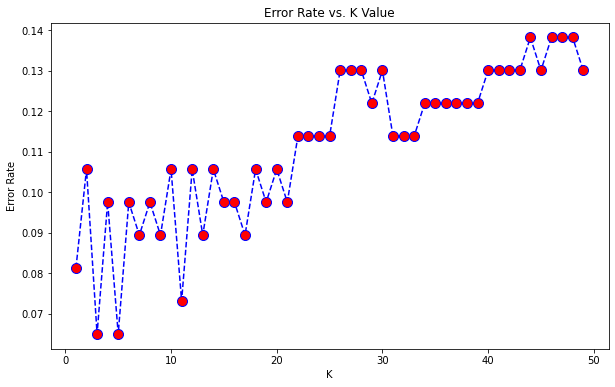

In [106]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,50):
     knn = KNeighborsClassifier(n_neighbors=i)
     knn.fit(X_train,y_train.ravel())
     pred_i = knn.predict(X_test)
     error_rate.append(np.mean(pred_i != y_test.ravel()))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [110]:
# Fitting K-NN to the Training set (3 variables)
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 3).fit(X_train, y_train.ravel())

In [111]:
# Predicting the Test set results
y_pred1 = knn.predict(X_test)
knn.score(X_test,y_test)

0.8943089430894309

In [112]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print(cm)

[[105   0]
 [ 13   5]]


Точность даной модели выше, чем модель Logistic regression - 89.4%. Также отсутствуют ложно-позитивные значения. 

## Support Vector Machine

In [113]:
# Fitting SVM to the Training set (3 variables)
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 5).fit(X_train, y_train.ravel())

In [114]:
# Predicting the Test set results
y_pred = svm.predict(X_test)
svm.score(X_test,y_test)

0.926829268292683

In [115]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[105   0]
 [  9   9]]


Модель Support Vector Machine является самой точной - 92.7%. Снизилось количество ложно-негативных значений с 15 и 13 (в пред. моделях) до 9.

## Naive Bayes

In [117]:
# Fitting Naive Bayes to the Training set (3 variables)
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(X_train, y_train.ravel())

In [118]:
# Predicting the Test set results
y_pred = nb.predict(X_test)
nb.score(X_test,y_test)

0.9024390243902439

In [119]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[104   1]
 [ 11   7]]


Модель Naive Bayes более точная чем Logistic regression и K-Nearest Neighbors, однако менее точная,чем Support Vector Machine. Ее точность составляет 90.2%. Появился один ложно-позитивный результат.

## Classification Tree

In [120]:
# Function Max Leaf
def max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeClassifier(max_leaf_nodes = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")

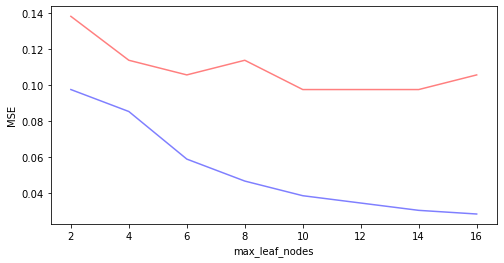

In [122]:
# The optimal number of max_leaf_nodes
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
max_leaf_nodes(X_train, X_test, y_train, y_test, [2, 4, 6, 8, 10,12,14,16])

In [123]:

# Fitting Classification Tree to the Training set (2 variables)
ct = DecisionTreeClassifier(max_leaf_nodes = 10, criterion = 'entropy', random_state = 5).fit(X_train, y_train)

In [124]:
# Predicting the Test set results
y_pred = ct.predict(X_test)
ct.score(X_test,y_test)

0.9186991869918699

In [125]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[105   0]
 [ 10   8]]


Модель Classification Tree с десятью моксимальными ветвлениями на втором месте по точности - 91.8%.

In [126]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestClassifier(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")

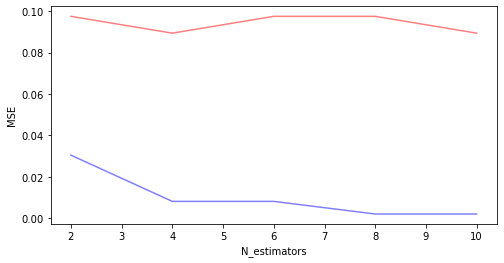

In [131]:
# The optimal number of trees 
from sklearn.ensemble import RandomForestClassifier    
rf_best_n_estimator(X_train, X_test, y_train.ravel(), y_test, [2, 4, 6, 8, 10])

In [139]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 5, max_leaf_nodes = 4, random_state = 5).fit(X_train, y_train.ravel())

In [140]:
y_pred = rf.predict(X_test)
y_pred = (y_pred > 0.5)
rf.score(X_test,y_test)

0.8861788617886179

In [135]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[105   0]
 [ 14   4]]


Модель Random Forest менее точная, чем  Classification Tree (88.6%)

## Classification Neural Network

In [39]:
# Install Tensorflow
# Install Keras
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

Using TensorFlow backend.


In [48]:
# Initialising the ANN 3-2-1
cnn1 = Sequential()

# Adding the input layer and the first hidden layer
cnn1.add(Dense(output_dim = 2, init = 'uniform', activation = 'relu', input_dim = 3))

# Adding the output layer
cnn1.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

C:\Users\RIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=3, units=2, kernel_initializer="uniform")`

C:\Users\RIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`



In [49]:
# Fitting the ANN to the Training set
cnn1.fit(X_train, y_train, batch_size = 10, nb_epoch = 100)

C:\Users\RIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/100
492/492 [==============================] - 0s 584us/step - loss: 0.6847 - accuracy: 0.8699
Epoch 2/100
492/492 [==============================] - 0s 77us/step - loss: 0.6680 - accuracy: 0.8699
Epoch 3/100
492/492 [==============================] - 0s 81us/step - loss: 0.6517 - accuracy: 0.8699
Epoch 4/100
492/492 [==============================] - 0s 81us/step - loss: 0.6364 - accuracy: 0.8699
Epoch 5/100
492/492 [==============================] - 0s 92us/step - loss: 0.6218 - accuracy: 0.8699
Epoch 6/100
492/492 [==============================] - 0s 85us/step - loss: 0.6079 - accuracy: 0.8699
Epoch 7/100
492/492 [==============================] - 0s 81us/step - loss: 0.5948 - accuracy: 0.8699
Epoch 8/100
492/492 [==============================] - 0s 81us/step - loss: 0.5823 - accuracy: 0.8699
Epoch 9/100
492/492 [==============================] - 0s 83us/step - loss: 0.5709 - accuracy: 0.8699
Epoch 10/100
492/492 [==============================] - 0s 81us/step - loss: 0.55

492/492 [==============================] - 0s 81us/step - loss: 0.3873 - accuracy: 0.8699
Epoch 81/100
492/492 [==============================] - 0s 77us/step - loss: 0.3872 - accuracy: 0.8699
Epoch 82/100
492/492 [==============================] - 0s 81us/step - loss: 0.3871 - accuracy: 0.8699
Epoch 83/100
492/492 [==============================] - 0s 81us/step - loss: 0.3871 - accuracy: 0.8699
Epoch 84/100
492/492 [==============================] - 0s 81us/step - loss: 0.3870 - accuracy: 0.8699
Epoch 85/100
492/492 [==============================] - 0s 79us/step - loss: 0.3870 - accuracy: 0.8699
Epoch 86/100
492/492 [==============================] - 0s 81us/step - loss: 0.3870 - accuracy: 0.8699
Epoch 87/100
492/492 [==============================] - 0s 85us/step - loss: 0.3869 - accuracy: 0.8699
Epoch 88/100
492/492 [==============================] - 0s 81us/step - loss: 0.3869 - accuracy: 0.8699
Epoch 89/100
492/492 [==============================] - 0s 81us/step - loss: 0.3869 - 

In [50]:
# Predicting the Test set results
y_pred6 = cnn1.predict(X_test)
y_pred6 = (y_pred6 > 0.5)

In [51]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred6)
print(cm1)

[[105   0]
 [ 18   0]]


In [54]:
# Initialising the ANN 9-2-1
cnn2 = Sequential()

# Adding the input layer and the first hidden layer
cnn2.add(Dense(output_dim = 2, init = 'uniform', activation = 'relu', input_dim = 9))

# Adding the output layer
cnn2.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

C:\Users\RIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=2, kernel_initializer="uniform")`

C:\Users\RIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`



In [55]:
# Fitting the ANN to the Training set
cnn2.fit(X_train, y_train, batch_size = 10, nb_epoch = 100)

C:\Users\RIE\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/100
492/492 [==============================] - 0s 590us/step - loss: 0.6807 - accuracy: 0.8699
Epoch 2/100
492/492 [==============================] - 0s 79us/step - loss: 0.6356 - accuracy: 0.8699
Epoch 3/100
492/492 [==============================] - 0s 87us/step - loss: 0.5641 - accuracy: 0.8699
Epoch 4/100
492/492 [==============================] - 0s 81us/step - loss: 0.4910 - accuracy: 0.8699
Epoch 5/100
492/492 [==============================] - 0s 79us/step - loss: 0.4389 - accuracy: 0.8699
Epoch 6/100
492/492 [==============================] - 0s 83us/step - loss: 0.4093 - accuracy: 0.8699
Epoch 7/100
492/492 [==============================] - 0s 83us/step - loss: 0.3960 - accuracy: 0.8699
Epoch 8/100
492/492 [==============================] - 0s 85us/step - loss: 0.3897 - accuracy: 0.8699
Epoch 9/100
492/492 [==============================] - 0s 81us/step - loss: 0.3854 - accuracy: 0.8699
Epoch 10/100
492/492 [==============================] - 0s 83us/step - loss: 0.38

492/492 [==============================] - 0s 85us/step - loss: 0.2562 - accuracy: 0.8699
Epoch 81/100
492/492 [==============================] - 0s 83us/step - loss: 0.2542 - accuracy: 0.8699
Epoch 82/100
492/492 [==============================] - 0s 79us/step - loss: 0.2526 - accuracy: 0.8841
Epoch 83/100
492/492 [==============================] - 0s 77us/step - loss: 0.2517 - accuracy: 0.8984
Epoch 84/100
492/492 [==============================] - 0s 77us/step - loss: 0.2497 - accuracy: 0.9004
Epoch 85/100
492/492 [==============================] - 0s 81us/step - loss: 0.2484 - accuracy: 0.8984
Epoch 86/100
492/492 [==============================] - 0s 81us/step - loss: 0.2469 - accuracy: 0.9004
Epoch 87/100
492/492 [==============================] - 0s 77us/step - loss: 0.2458 - accuracy: 0.9004
Epoch 88/100
492/492 [==============================] - 0s 77us/step - loss: 0.2438 - accuracy: 0.9085
Epoch 89/100
492/492 [==============================] - 0s 81us/step - loss: 0.2424 - 

In [56]:
# Predicting the Test set results
y_pred7 = cnn2.predict(X_test)
y_pred7 = (y_pred7 > 0.5)

In [57]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, y_pred7)
print(cm2)

[[105   0]
 [ 16   2]]


## Выводы:
- Наилучшей моделью классификации является модель Support Vector Machine. Ее точность составила 92.6%, 9 ложно-негативных значений.
- Наименее точной моделью является Logistic regression - 87.8%. Также с задачей классификации на даном датасете плохо справились нейронные сети. Были проведены эксперементы с архитектурой сетей, однако все сети плохо распознают ложние значения.
- Все модели имеют достаточно высокую точность.
- Практически все модели не показывали ложно-позитивные значения (кроме модели Naive Bayes).

# Кластеризация

В кластеризации не будет использоваться переменная Category

In [147]:
df = df.drop(columns = 'Category')

In [157]:
df.head()

Age  Sex       ALP       ALT       CHE      CHOL      CREA       GGT  \
0  0.224138  1.0  0.401661  0.230063  0.404413  0.185619  0.440338  0.241512   
1  0.224138  1.0  0.547881  0.448334  0.724900  0.416890  0.296554  0.303547   
2  0.224138  1.0  0.578285  0.627930  0.548783  0.475813  0.350473  0.487961   
3  0.224138  1.0  0.396869  0.584731  0.434648  0.408052  0.323514  0.492334   
4  0.224138  1.0  0.574246  0.601005  0.572215  0.346183  0.305541  0.462398   

       PROT  
0  0.416599  
1  0.653954  
2  0.742566  
3  0.628636  
4  0.407104

In [153]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler().fit(df)
df = sc.transform(df)
df = pd.DataFrame(df, columns = ['Age', 'Sex', 'ALP','ALT','CHE','CHOL','CREA','GGT', 'PROT'])

In [156]:
df.head()

Age  Sex       ALP       ALT       CHE      CHOL      CREA       GGT  \
0  0.224138  1.0  0.401661  0.230063  0.404413  0.185619  0.440338  0.241512   
1  0.224138  1.0  0.547881  0.448334  0.724900  0.416890  0.296554  0.303547   
2  0.224138  1.0  0.578285  0.627930  0.548783  0.475813  0.350473  0.487961   
3  0.224138  1.0  0.396869  0.584731  0.434648  0.408052  0.323514  0.492334   
4  0.224138  1.0  0.574246  0.601005  0.572215  0.346183  0.305541  0.462398   

       PROT  
0  0.416599  
1  0.653954  
2  0.742566  
3  0.628636  
4  0.407104

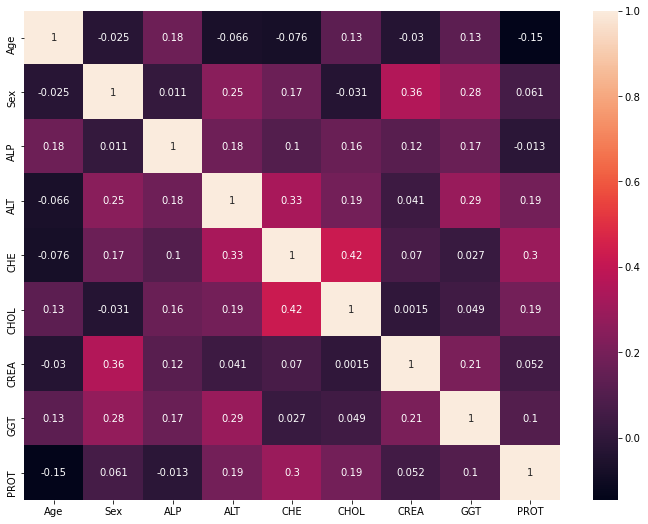

In [154]:
# Cheking correlations
import seaborn as sns
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True)
plt.show()

Видим, что сильная корреляция между переменными отсутствует. Переменные CHE и CHOL коррелируют наибольше. 

## Hierarchical Clustering

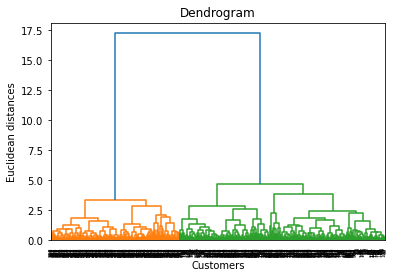

In [159]:
# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

Оптимальное число кластеров, судя по дендограмме равно двум.

In [170]:
# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward').fit_predict(df)

In [171]:
hc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## K-Means Clustering

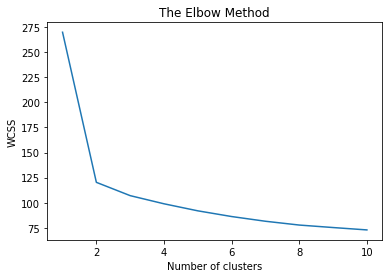

In [172]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 8)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

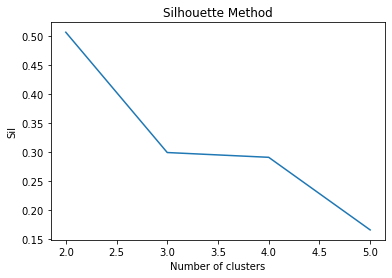

2:0.506947666217463
3:0.2992782587967207
4:0.2910213144693223
5:0.1656737253009641


In [173]:
from sklearn.metrics import silhouette_score

sil = []

for k in range(2, 6):
  kmeans = KMeans(n_clusters = k).fit(df)  
  preds = kmeans.fit_predict(df)
  sil.append(silhouette_score(df, preds, metric = 'euclidean'))


plt.plot(range(2, 6), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

Исходя из графических методов  elbow method и  silhouette, оптимальное число кластеров также равно двум. В  elbow method наиболее резкое снижение наблюдается от одного до двух, а в методе силуэта, два имеет наибольшее значение.

In [178]:
cols = df.columns.values

In [184]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0).fit_predict(df)
kms = KMeans(n_clusters = 2, random_state = 5).fit(df)
pd.DataFrame(kms.cluster_centers_, columns = cols).round(3)

Age  Sex    ALP    ALT    CHE   CHOL   CREA    GGT   PROT
0  0.486  1.0  0.506  0.542  0.522  0.496  0.344  0.477  0.523
1  0.495  0.0  0.503  0.460  0.465  0.507  0.280  0.372  0.503

In [185]:
# Comparing Clustering Algorithms
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(hc,km)

0.9934794544950727

Иерархическая кластеризация и кластеризация с помощью метода к-средних схожи на 99%, что говорит о значимости их результатов.

## SOM 

In [198]:
import SimpSOM as sps
np.random.seed(5)
df_array=df.values
net = sps.somNet(20, 20, df_array, PBC=True)
net.train(0.01, 2000)
#net.save(‘filename_weights’)

Periodic Boundary Conditions active.
The weights will be initialised randomly.
Training SOM... done!


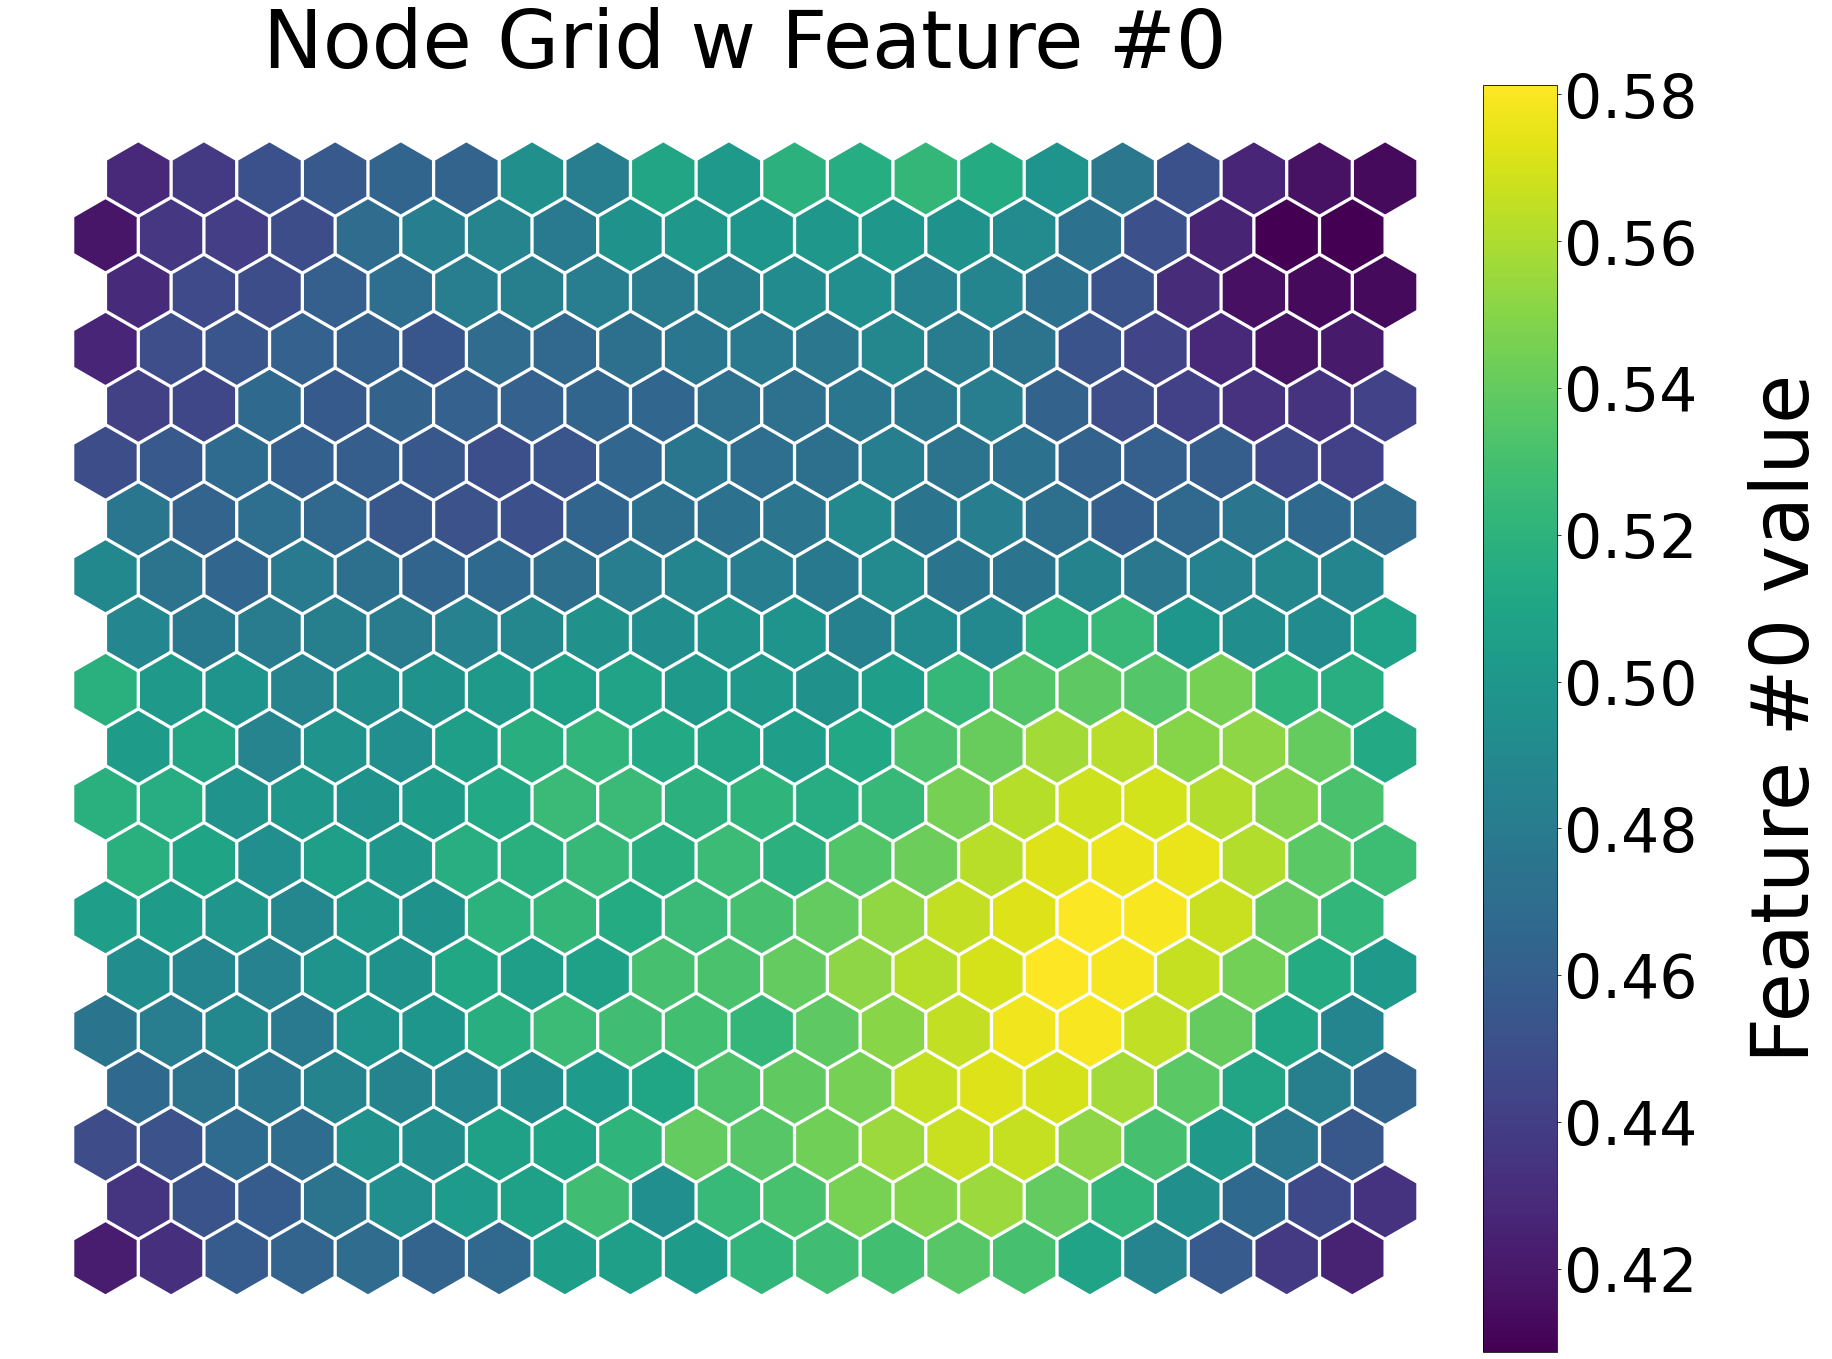

In [199]:
net.nodes_graph(colnum=0)

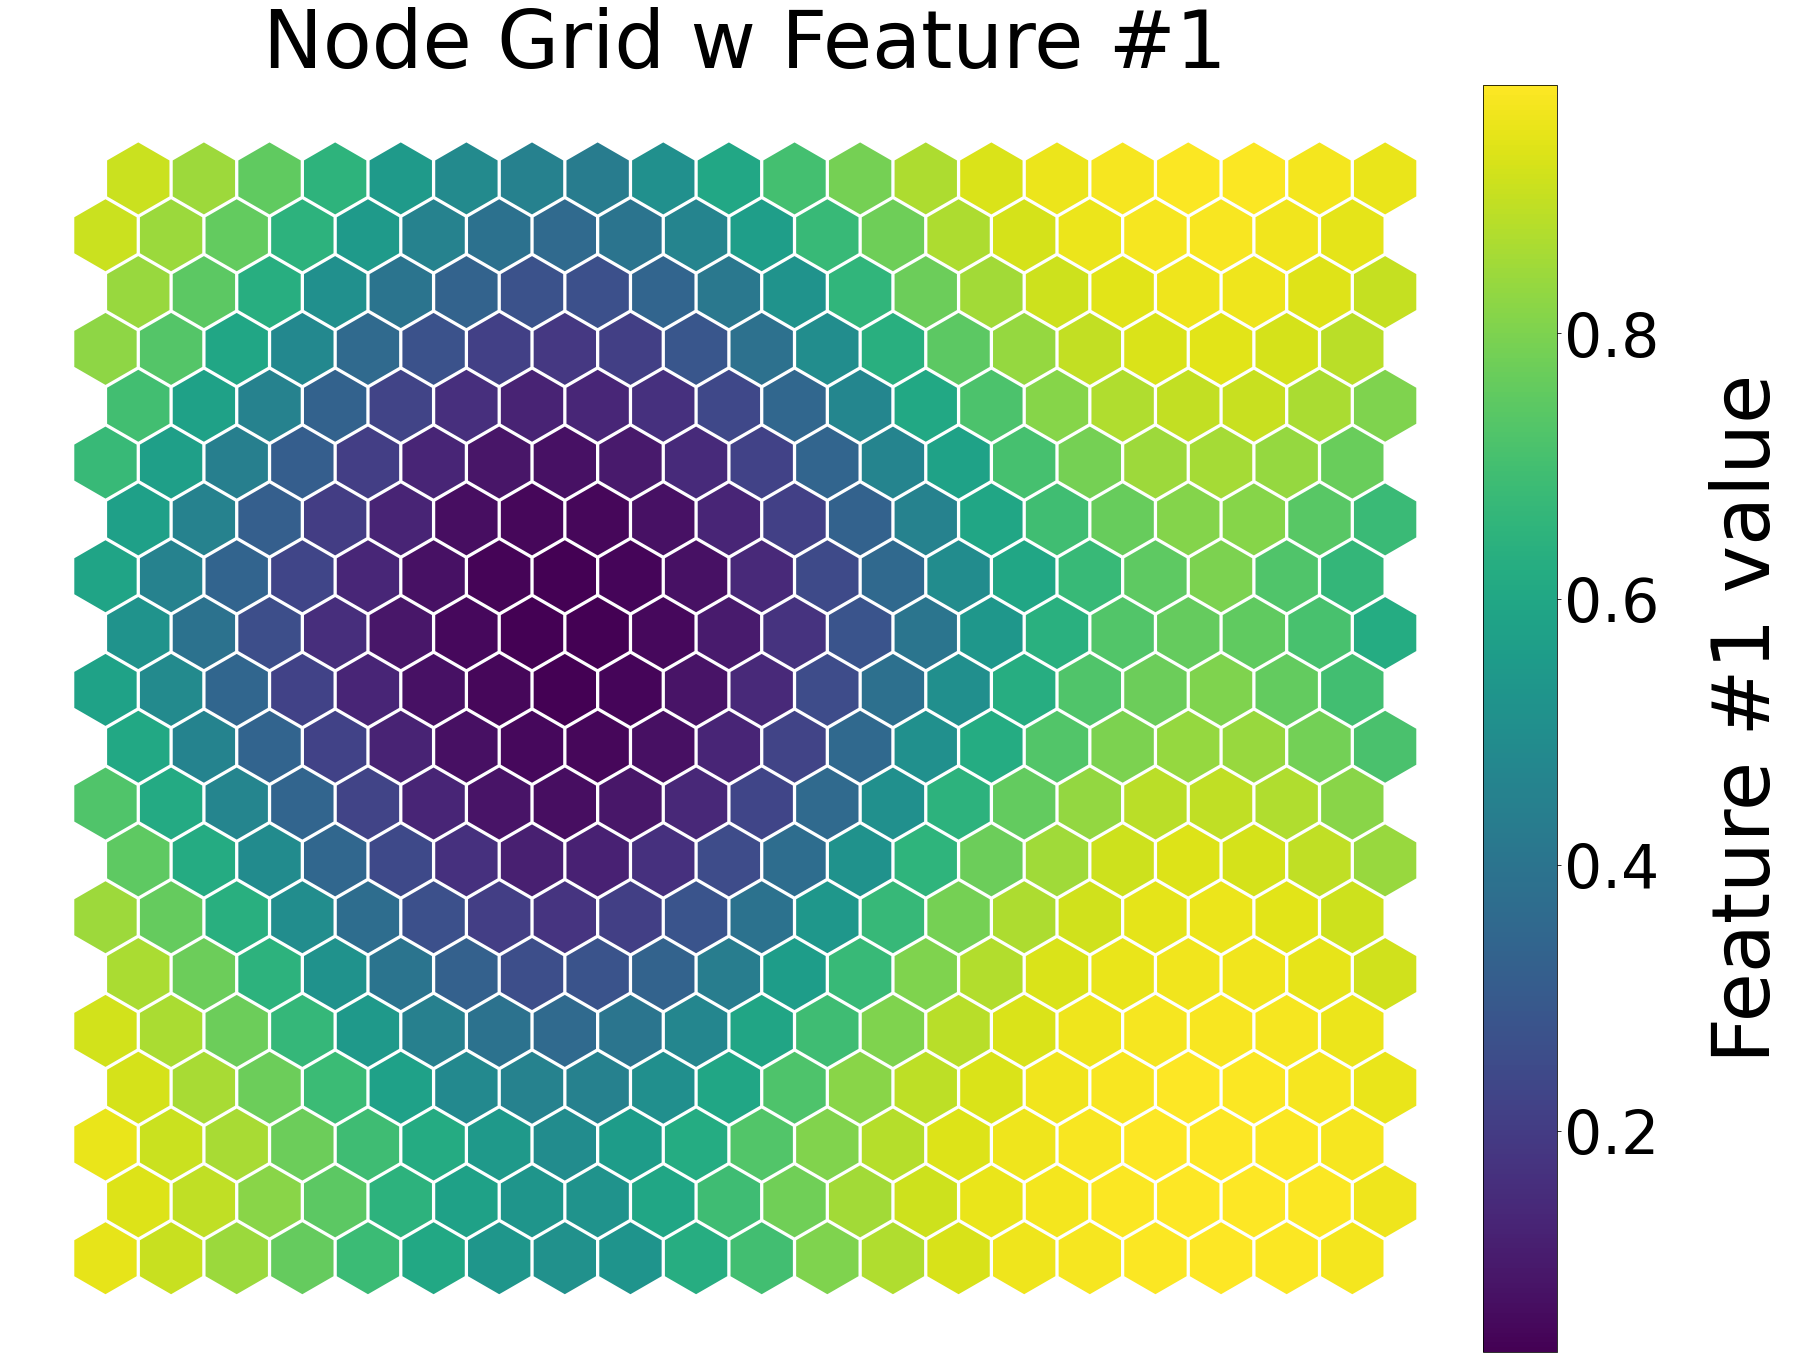

In [200]:
net.nodes_graph(colnum=1)

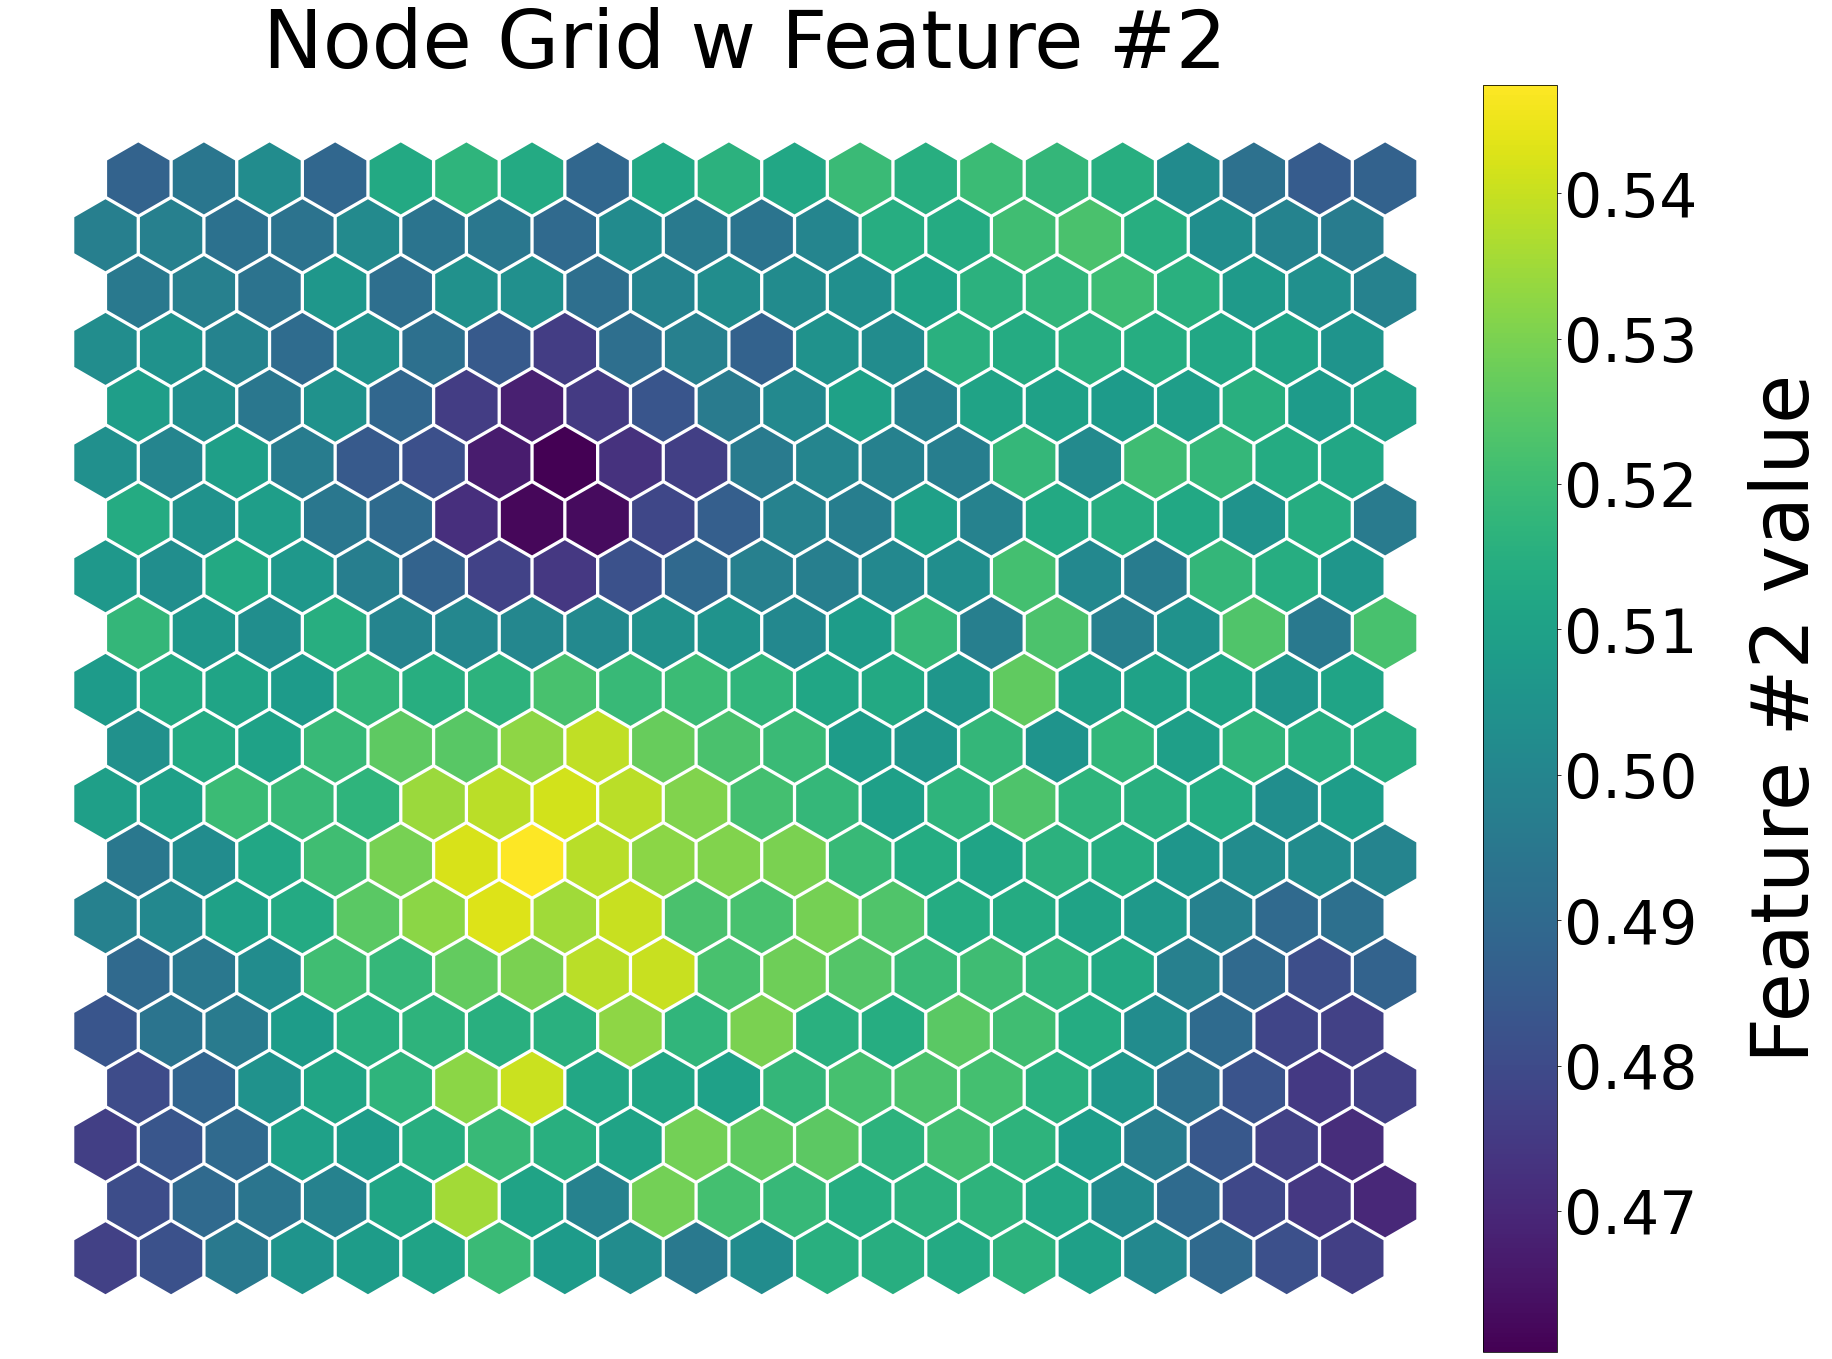

In [201]:
net.nodes_graph(colnum=2)

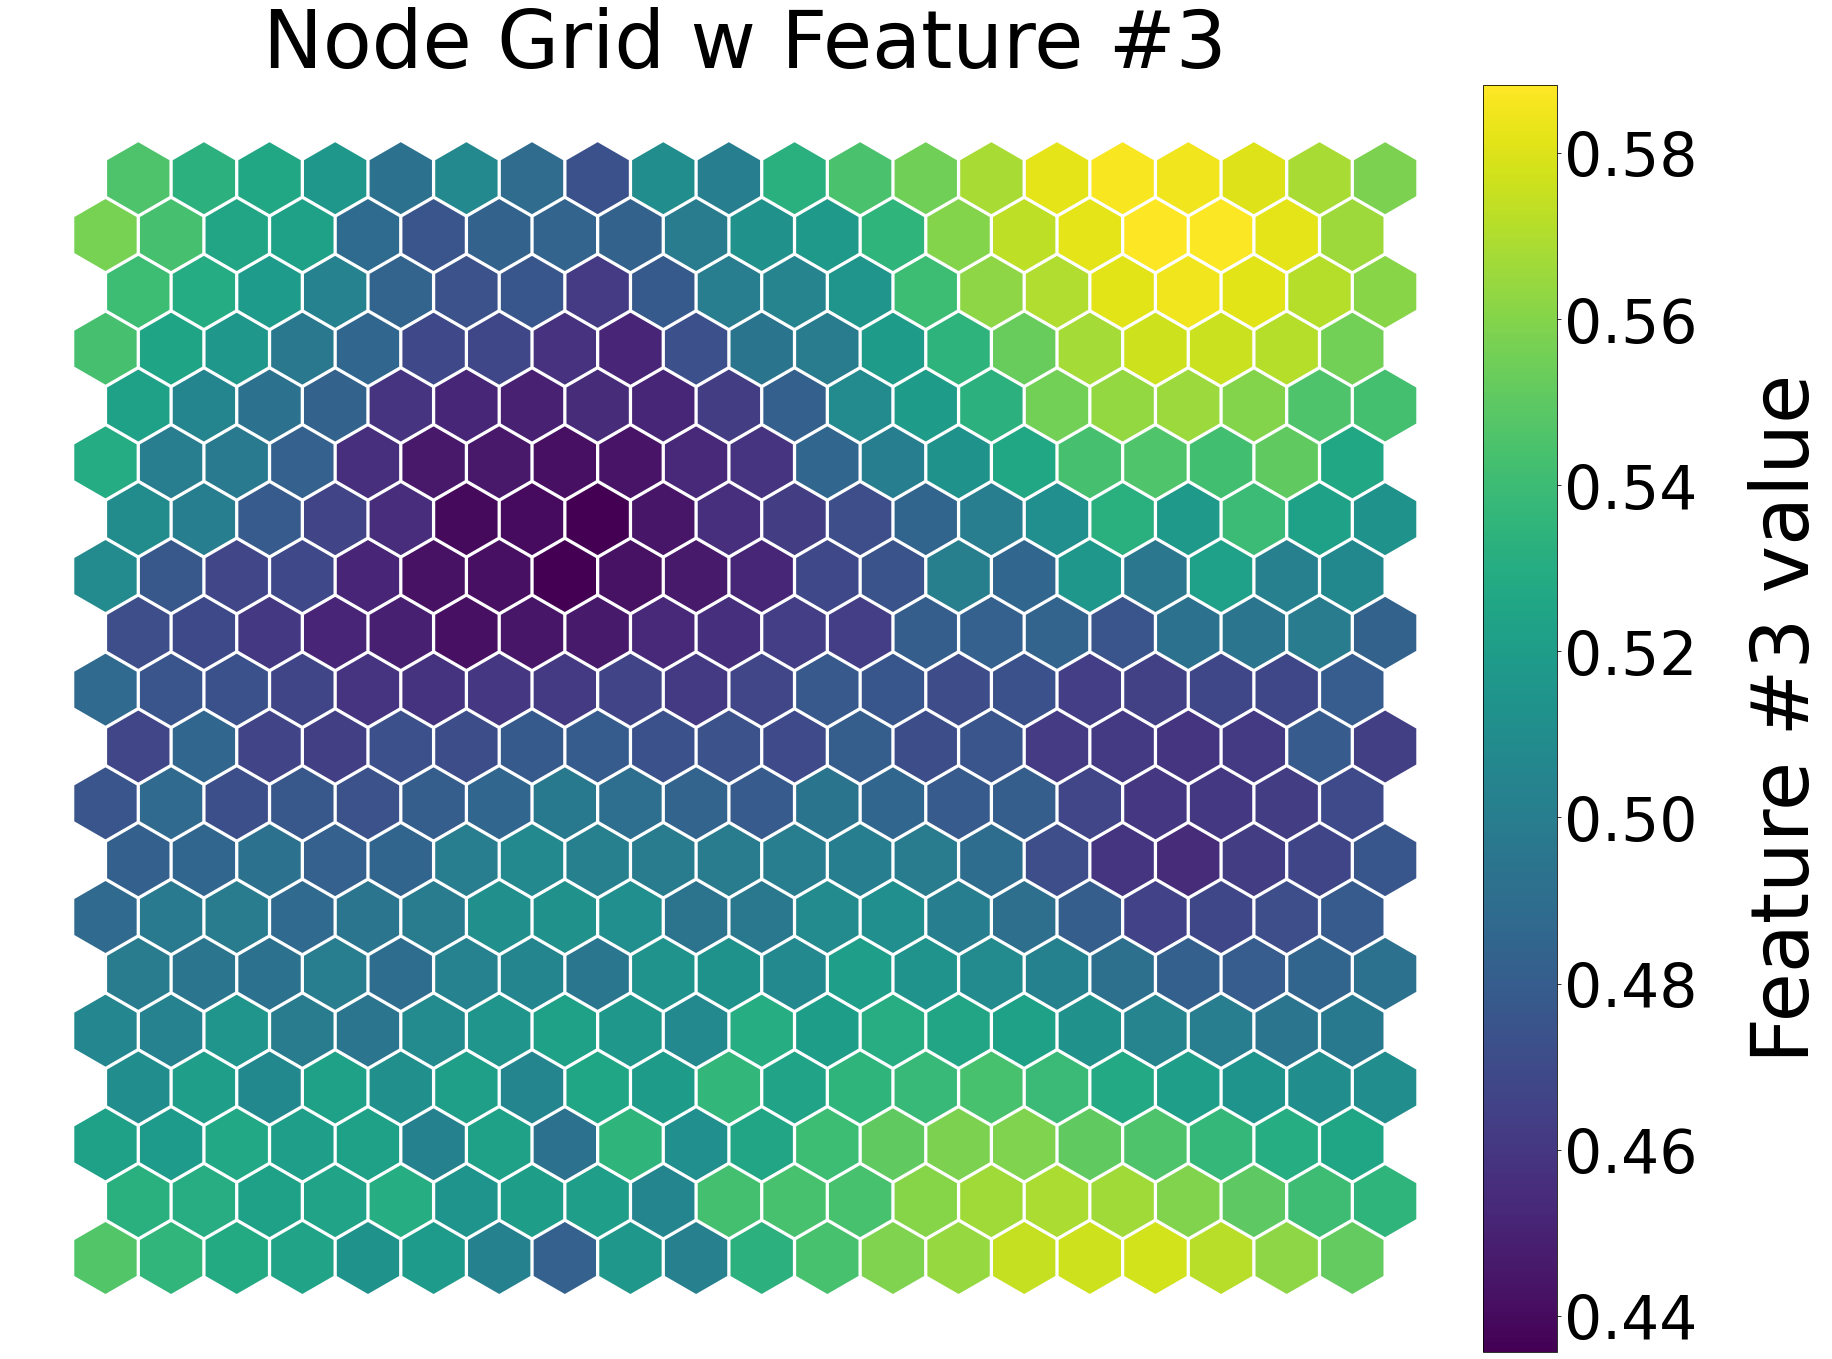

In [202]:
net.nodes_graph(colnum=3)

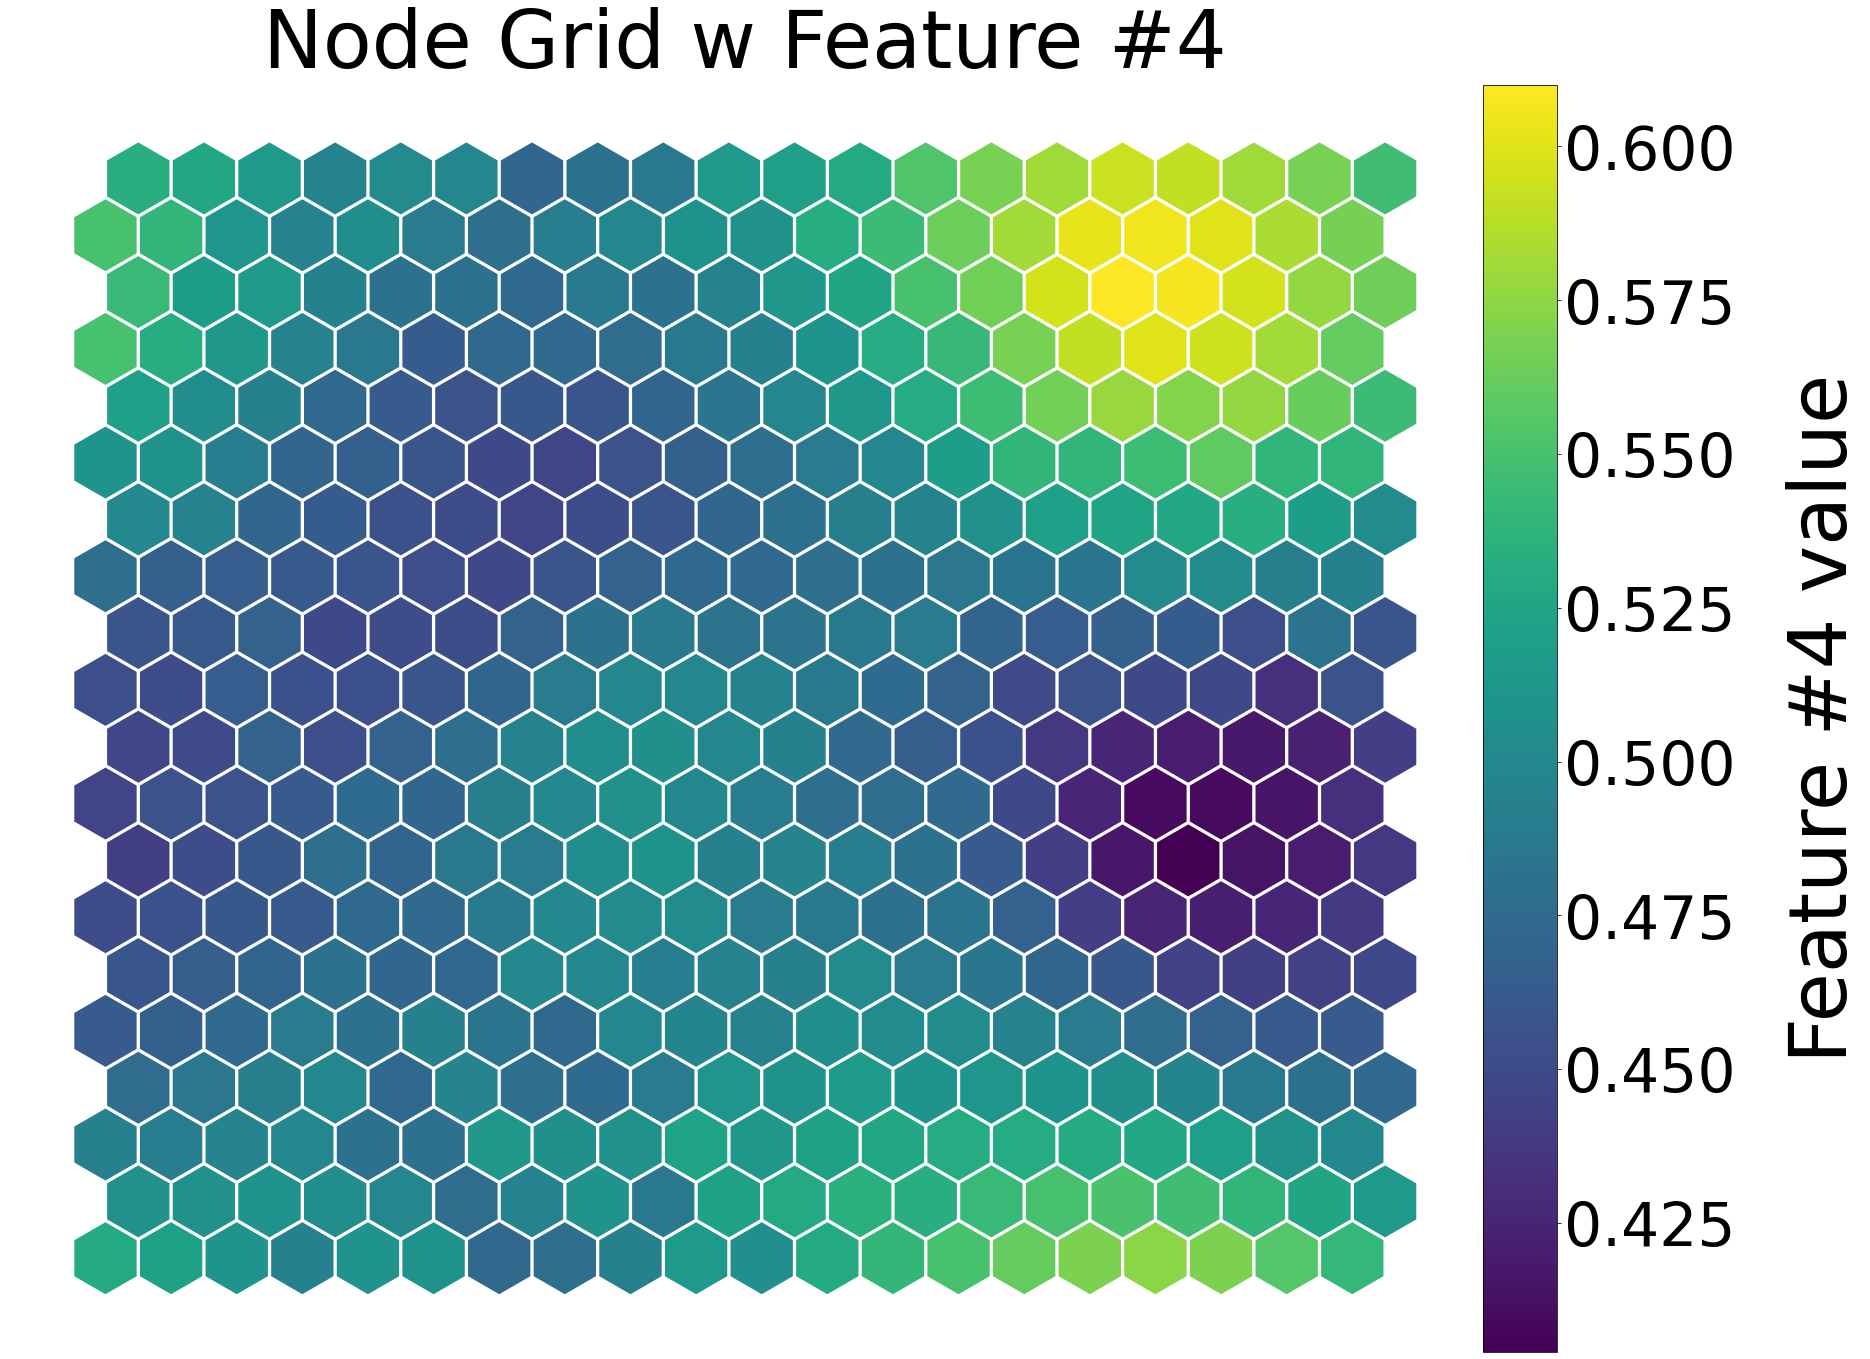

In [203]:
net.nodes_graph(colnum=4)

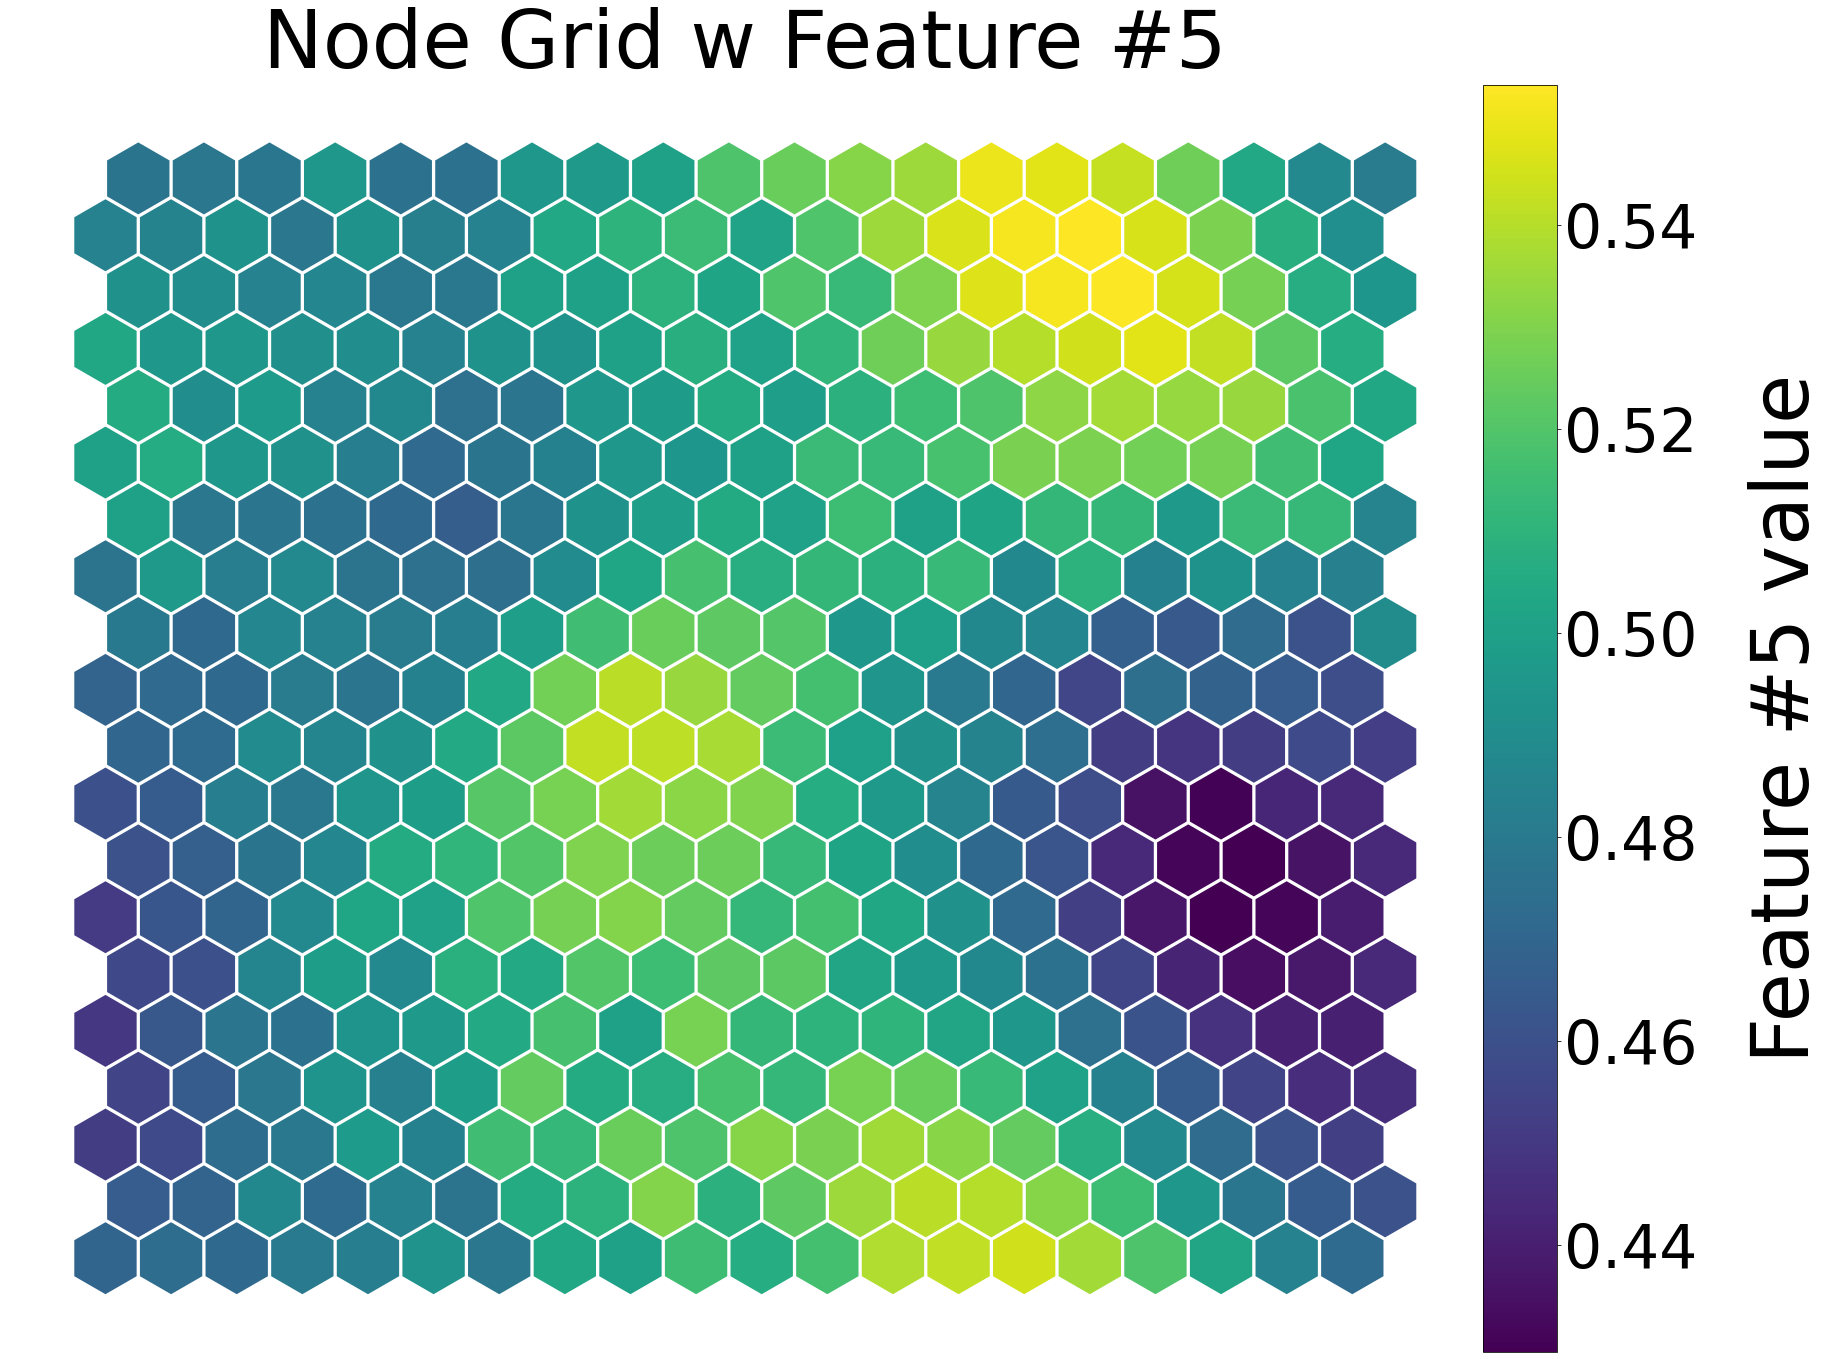

In [204]:
net.nodes_graph(colnum=5)

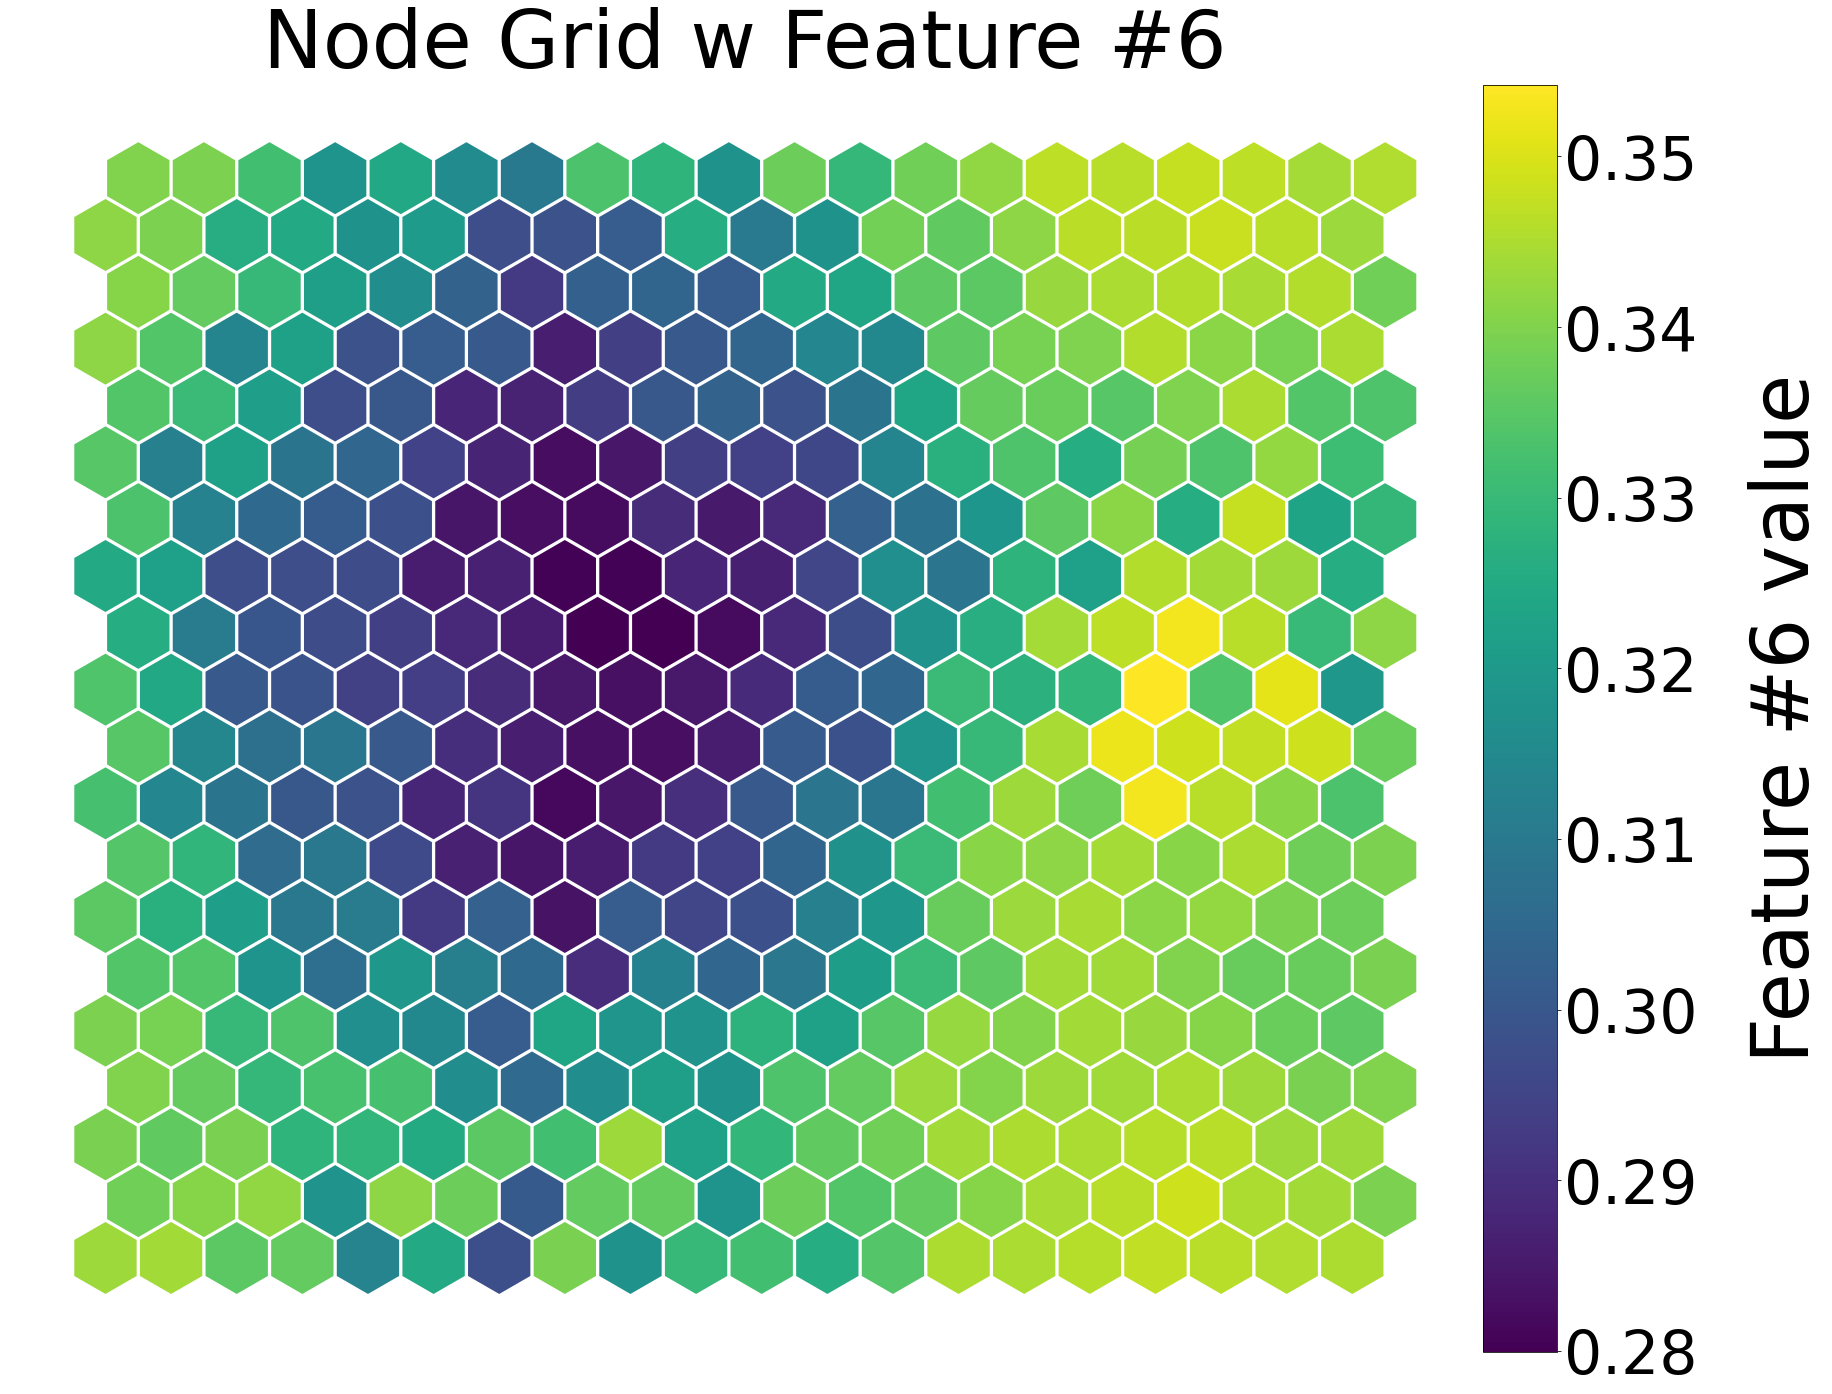

In [205]:
net.nodes_graph(colnum=6)

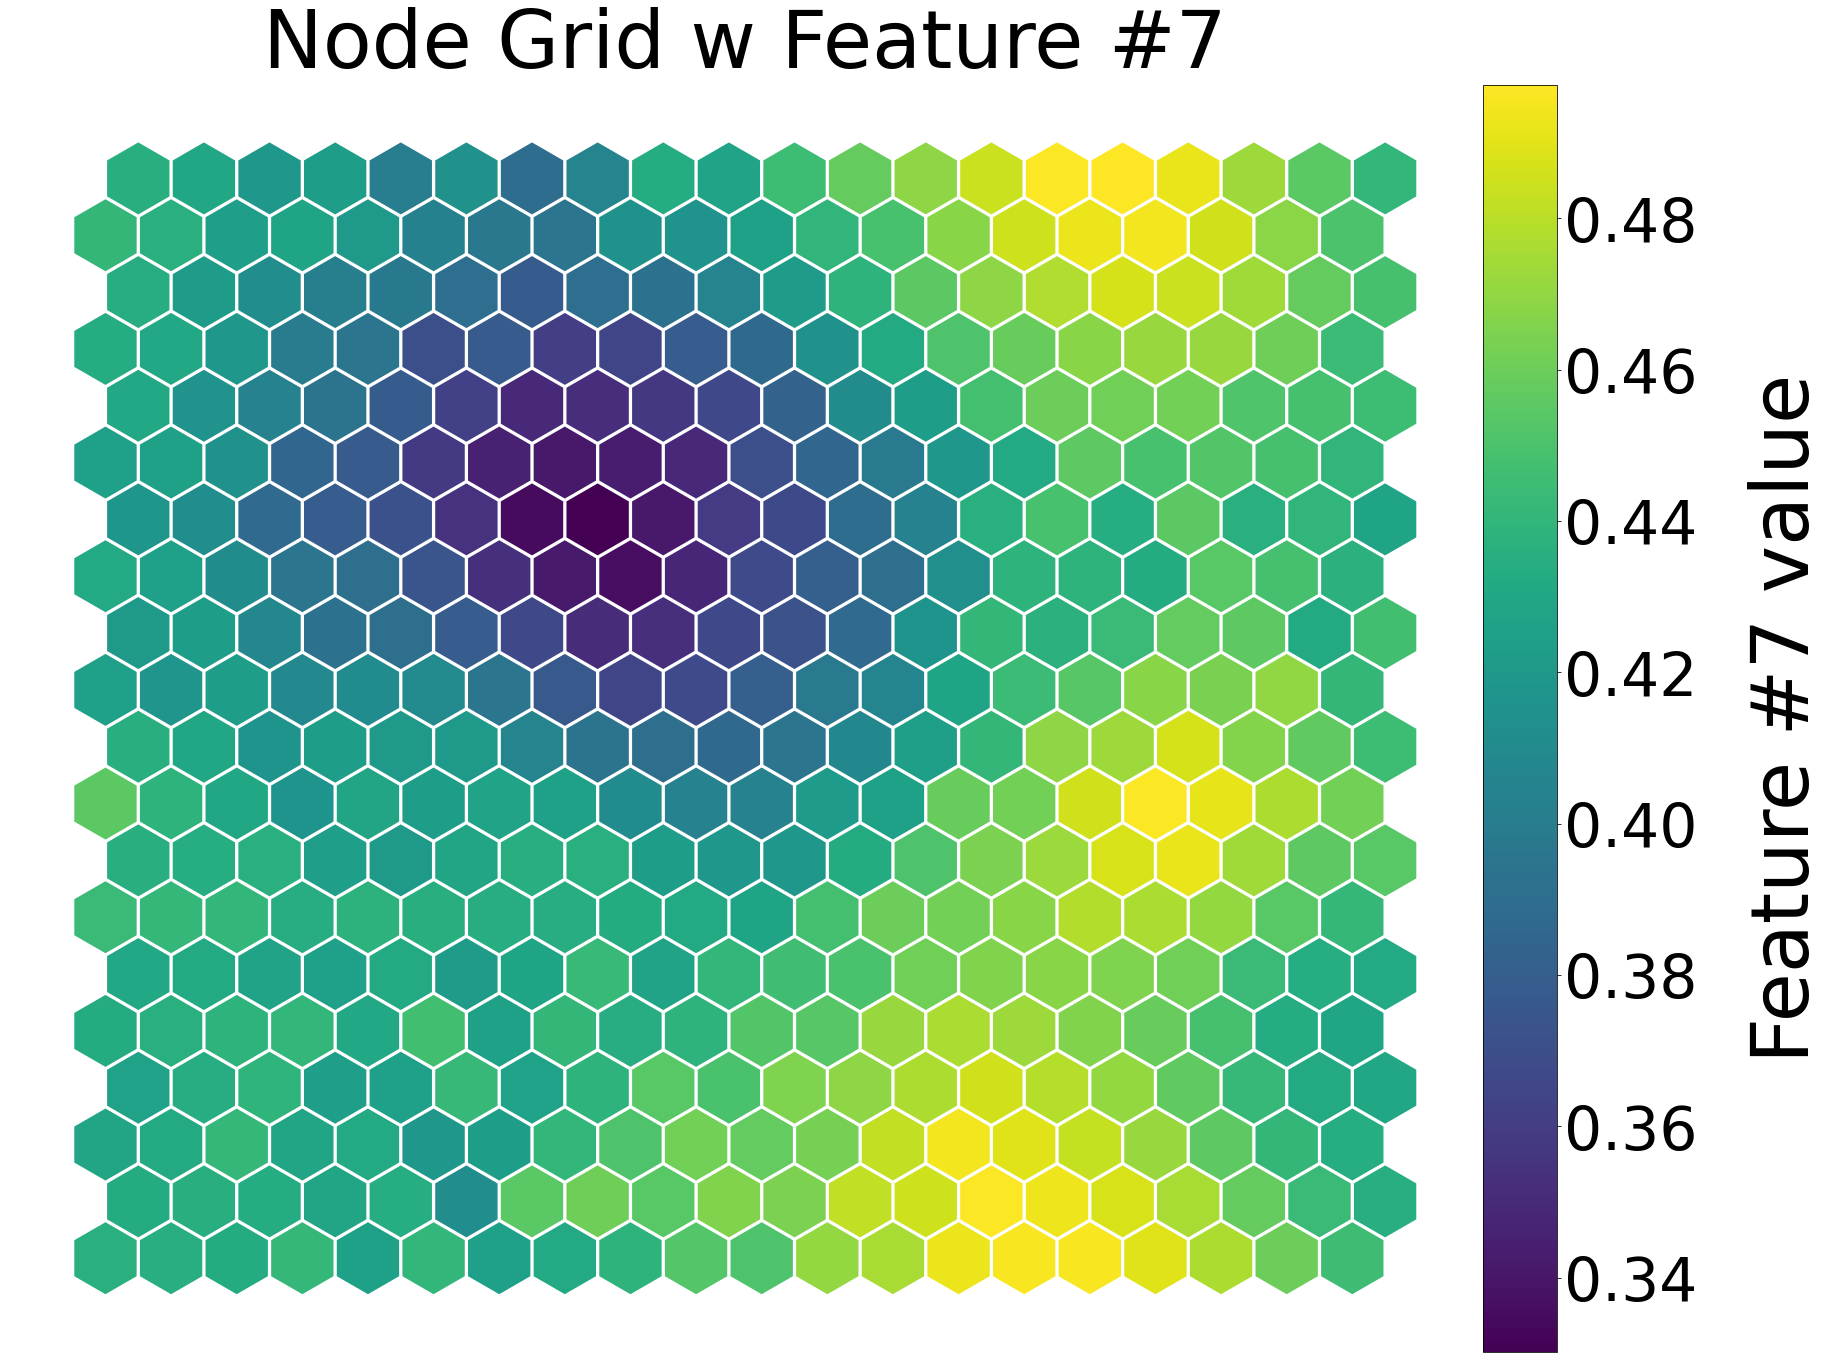

In [206]:
net.nodes_graph(colnum=7)

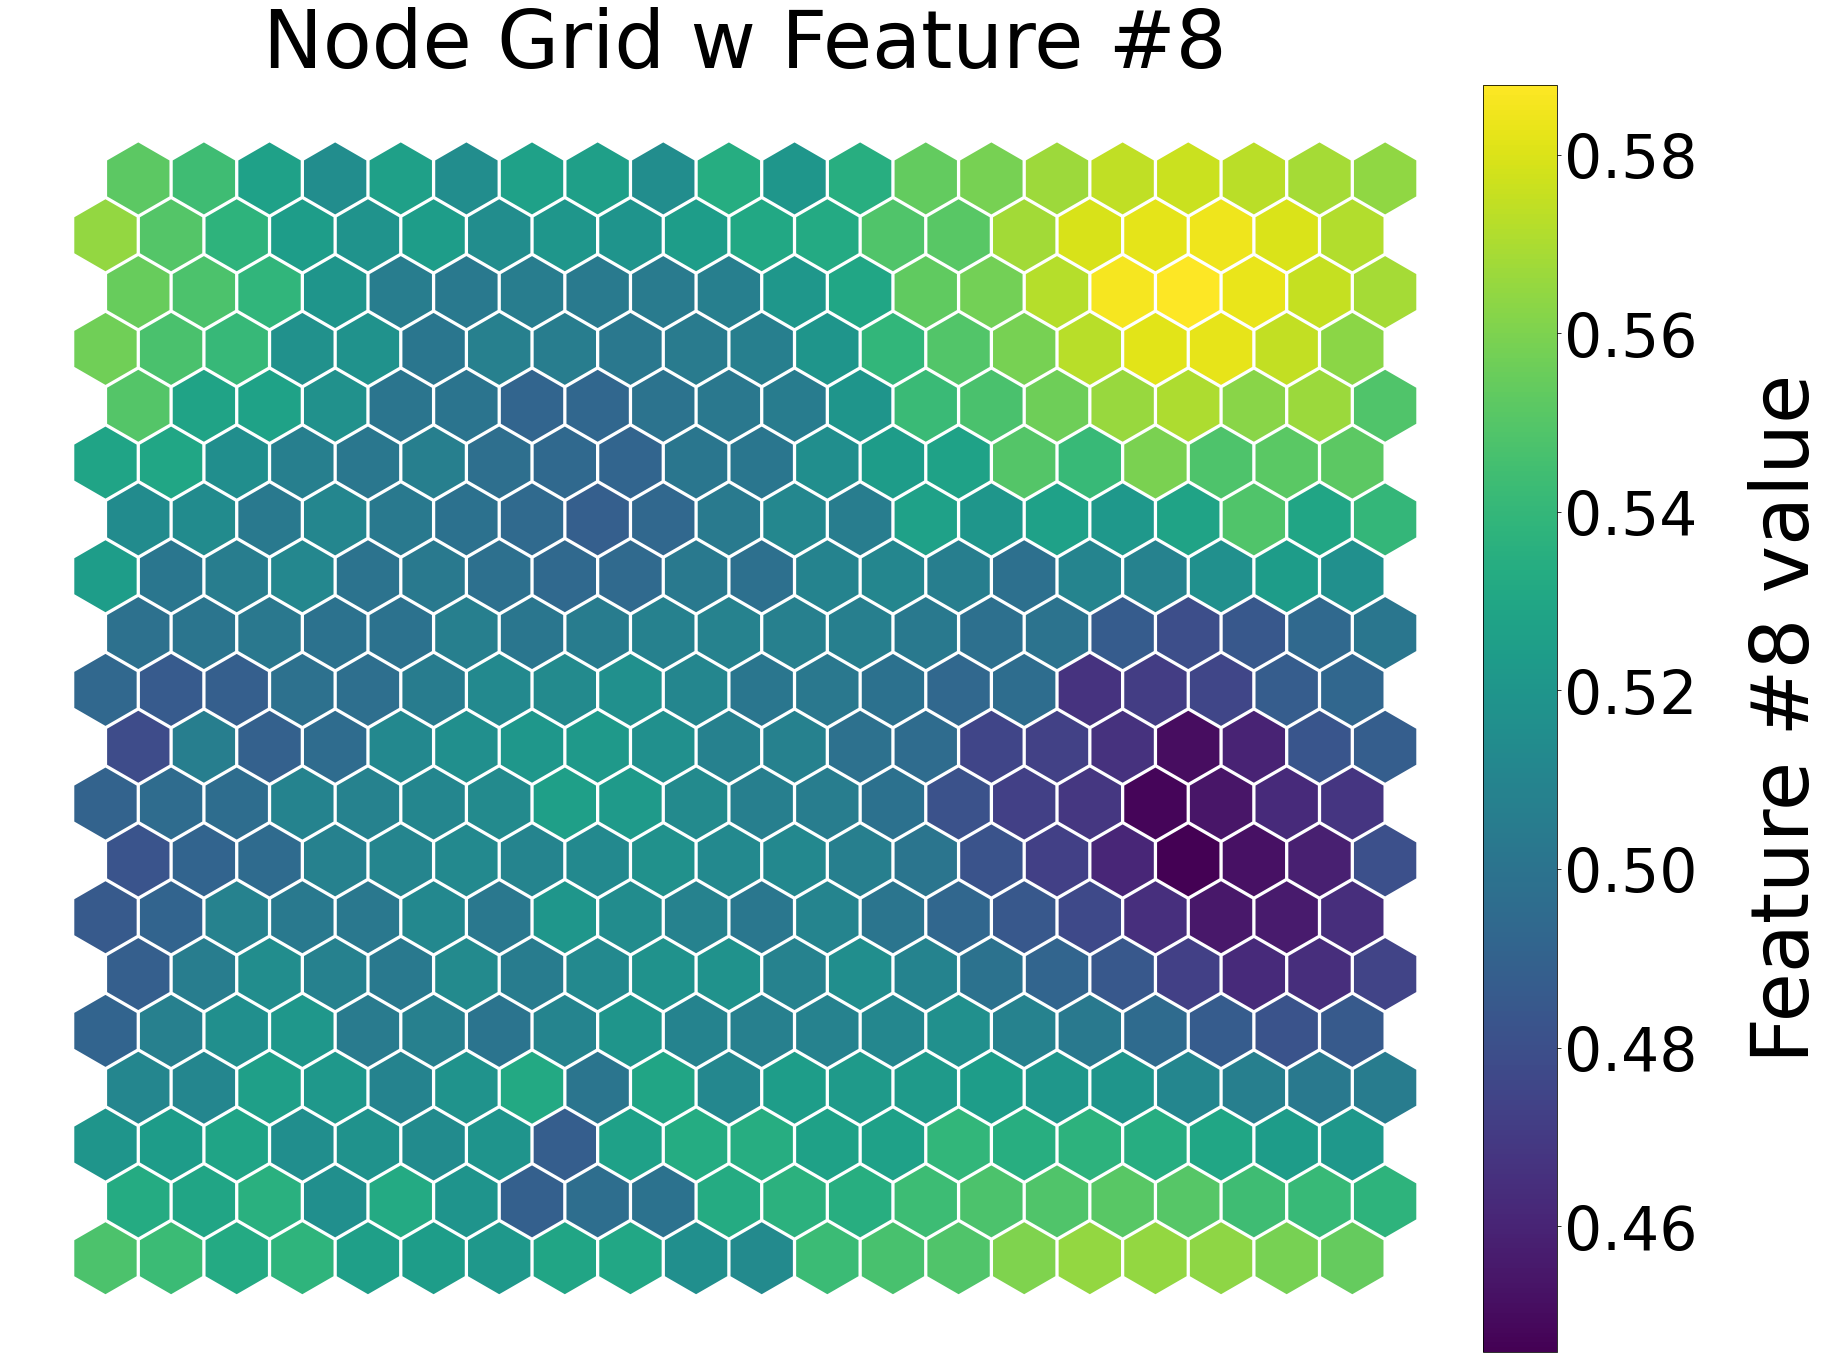

In [207]:
net.nodes_graph(colnum=8)

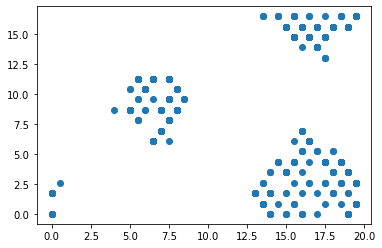

In [209]:
prj=np.array(net.project(df.values))
plt.scatter(prj.T[0],prj.T[1])
plt.show()

На графикевидно, что выделяется 3 четки-х кластера и еще один, состоящий из малого числа точек. 

In [210]:
# Fitting kmeans to SOM
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(prj)

In [212]:
# Comparing Clustering Algorithms
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(km,kmeans.labels_)

0.9169672608341973

Методы также достаточно сильно перескаются. 

## Выводы
- Были применены различные методы клоастеризаций к даному датасету: SOM, KMeans, HC. 
- Кластеризация по всем методам проводилась с использвоанием всех переменных, поскольку при анализе корреляционной матрици небыло выявлено сильной корреляции между парами переменных (все коэфициенты меньше 0,5).
- Результаты кластеризации разных моделей в значительной мере схожи. Более отличные результаты были получены с использованием карт Кохонена. 
- Оптимальное количество кластеров равно двух по методам дендограммы, силуэтта и Элбоу. Только по методу СОМ выделяется 3 кластера. 
- Первыцй выделенный кластер содержит мужчин, второй - женщин с возрастом выше. Показатели ALP практически идентичны, Показатели ALT, CHE, CREA, GGT, PROT выше в первом кластере.